In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn import impute
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

import warnings
warnings.simplefilter(action='ignore')

# Obtain Data

In [2]:
DATA_SET = fetch_olivetti_faces()
display(Markdown(DATA_SET['DESCR']))

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes                                40
    Samples total                         400
    Dimensionality                       4096
    Features            real, between 0 and 1
    =================   =====================

The image is quantized to 256 grey levels and stored as unsigned 8-bit 
integers; the loader will convert these to floating point values on the 
interval [0, 1], which are easier to work with for many algorithms.

The "target" for this database is an integer from 0 to 39 indicating the
identity of the person pictured; however, with only 10 examples per class, this
relatively small dataset is more interesting from an unsupervised or
semi-supervised perspective.

The original dataset consisted of 92 x 112, while the version available here
consists of 64x64 images.

When using these images, please give credit to AT&T Laboratories Cambridge.


## Sample Plot

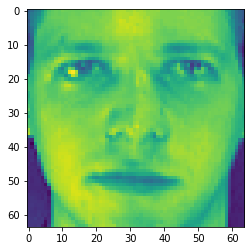

In [3]:
plt.imshow(DATA_SET['images'][0])

##  Get Training and Test Data

Get training an test data.

In [4]:
X = DATA_SET['data']
y = DATA_SET['target']

Split into training and test data.

In [5]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y): #this is only a single loop
    X_train = X[train_index] 
    X_test = X[test_index] 
    y_train = y[train_index] 
    y_test = y[test_index] 

# Clustering

## Experimenting with different clusters.

Try a bunch of different clusters.

In [6]:
%%capture
clusters = [2, 3, 5, 7, 10, 17, 25, 32, 40, 45, 55, 75, 125, 150, 175]
diff_kmeans = [KMeans(n_clusters=i) for i in clusters]
[diff_kmean.fit(X_train) for diff_kmean in diff_kmeans]

Obtain scores and inertias for each kmean algorithm.

In [7]:
scores = np.array([silhouette_score(X_train,k_mean.labels_) for k_mean in diff_kmeans])
inertias = np.array([k_mean.inertia_ for k_mean in diff_kmeans])

Plot

[None, None]

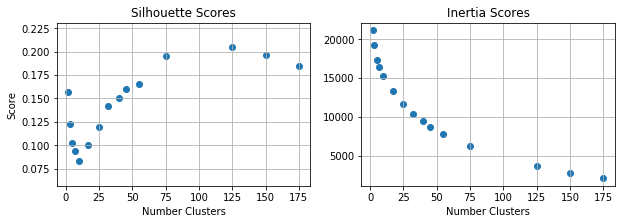

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].set_title('Silhouette Scores')
ax[0].set_xlabel('Number Clusters')
ax[0].set_ylabel('Score')
ax[0].scatter(clusters, scores)

ax[1].set_title('Inertia Scores')
ax[1].set_xlabel('Number Clusters')
ax[1].scatter(clusters, inertias)

[a.grid() for a in ax]
plt.show()

## Choose Cluster

Pick 40 clusters.

In [9]:
kmean = KMeans(n_clusters=100)
kmean.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=100, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Plot some of the faces in each cluster.

In [10]:
# Nice Pythonic way to get the indices of the points for each corresponding cluster
mydict = {i: np.where(kmean.labels_ == i)[0] for i in range(kmean.n_clusters)}

Sample 1

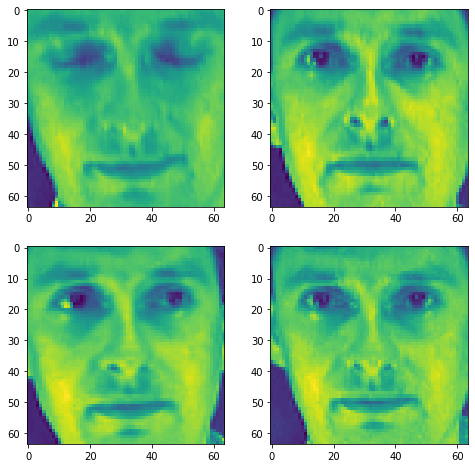

In [11]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
ax[0][0].imshow(X_train[mydict[0][0]].reshape(64,64))
ax[0][1].imshow(X_train[mydict[0][1]].reshape(64,64))
ax[1][0].imshow(X_train[mydict[0][2]].reshape(64,64))
ax[1][1].imshow(X_train[mydict[0][3]].reshape(64,64))

Sample 2

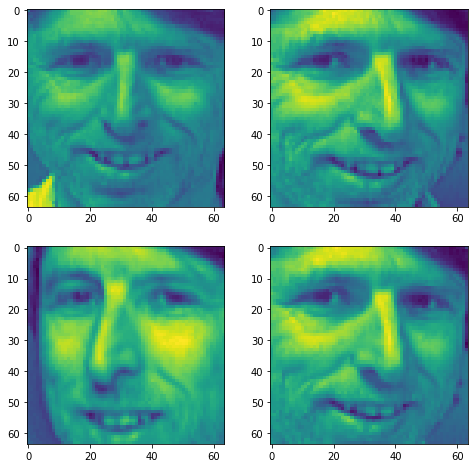

In [12]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
ax[0][0].imshow(X_train[mydict[2][0]].reshape(64,64))
ax[0][1].imshow(X_train[mydict[2][1]].reshape(64,64))
ax[1][0].imshow(X_train[mydict[2][2]].reshape(64,64))
ax[1][1].imshow(X_train[mydict[2][3]].reshape(64,64))

Possibly some mistakes.

# Training Models

## Train on regular data.

In [13]:
# Train 3 different classifiers
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=20, max_depth=10, criterion='entropy', random_state=41)
svm_clf = SVC(gamma="auto", random_state=42, probability = True)
 
# Combine them to make voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

# Print all scores
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
# 

LogisticRegression 0.975
RandomForestClassifier 0.8875
SVC 0.7875
VotingClassifier 0.975


## Logistic Regression with kmeans

In [14]:
pipeline = Pipeline([
    ('kmean', KMeans()),
    ('log_reg', LogisticRegression(solver="liblinear", random_state=42))
])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'kmean__n_clusters': [40, 55, 70, 95, 110, 125, 140, 155, 170],
}

search = GridSearchCV(pipeline, param_grid, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.925):
{'kmean__n_clusters': 140}


In [15]:
y_pred = search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9375

## Use Gaussian Mixture Model with PCA

Convert data to principal components and retain 95% of variance

In [86]:
pca = PCA(n_components=0.95)
X_train_red = pca.fit_transform(X_train)
X_test_red = pca.fit_transform(X_train)

Train Gaussian Mixture.

In [87]:
gm = GaussianMixture(n_components=110, n_init=10)
gm.fit(X_train_red)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=110, n_init=10,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Plot a randomly generated sample.

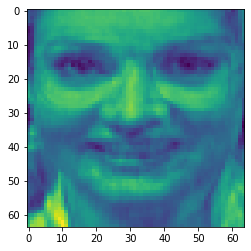

In [88]:
plt.imshow(pca.inverse_transform(gm.sample()[0][0]).reshape(64,64))

## Anomaly Detection

In [89]:
densities = gm.score_samples(X_train_red)

Look at all the densities

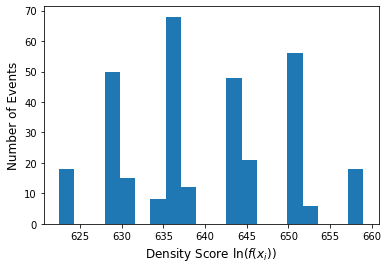

In [90]:
plt.hist(densities, bins=20)
plt.xlabel('Density Score $\ln(f(x_i))$', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.show()

In [92]:
low_densities = X_train_red[densities<625]
high_densities = X_train_red[densities>655]

Text(0.5, 1.0, 'Image Didnt Fit Well in Cluster')

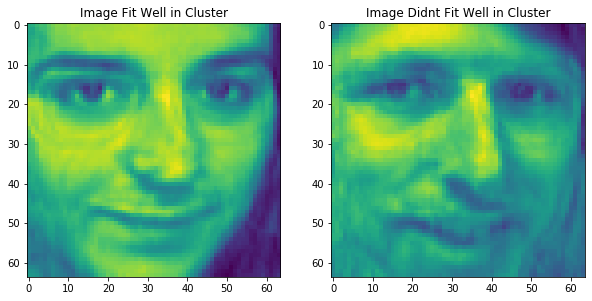

In [101]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(pca.inverse_transform(high_densities[0]).reshape(64,64))
ax[1].imshow(pca.inverse_transform(low_densities[8]).reshape(64,64))

ax[0].set_title('Image Fit Well in Cluster')
ax[1].set_title('Image Didnt Fit Well in Cluster')